In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dataclasses import asdict
from datetime import datetime
import cartopy.crs as ccrs
import easygems.healpix as egh
import intake
import matplotlib.pyplot as plt
import numpy as np
import orcestra
import orcestra.flightplan as fp
import orcestra.sat
from orcestra.flightplan import LatLon, IntoCircle, bco, sal, mindelo, find_ec_lon, vertical_preview, to_kml\

def ec_time_at_lat(ec_track, lat):
    e = np.datetime64("2024-08-01")
    s = np.timedelta64(1, "ns")
    return (((ec_track.swap_dims({"time":"lat"}).time - e) / s).interp(lat=lat) * s + e)

# Global coordinates and definitions that should not change from flight to flight

lon_min, lon_max, lat_min, lat_max = -65, -5, -5, 25

radius = 130e3
atr_radius = 72e3

band = "east"
airport = sal if band == "east" else bco
natal = LatLon(-5 - 47/60. - 42.00/3600.,-35 - 12/60. - 33.98/3600., label = "natal")

In [3]:
# Basic information
lon_min, lon_max, lat_min, lat_max = -65, -5, -5, 25

# Define dates for forecast initialization and flight

issued_time = datetime(2024, 8, 24, 0, 0, 0)

flight_time = datetime(2024, 8, 27, 12, 0, 0)
flight_index = f"HALO-{flight_time.strftime('%Y%m%d')}a"

# adjust takeoff time to match EC overpass
takeoff_time = np.datetime64("2025-08-27T10:11:21.4285")

print(
    f"Initalization date of IFS forecast: {issued_time}\n"
    f"Flight date: {flight_time:%Y-%m-%d}\n"
    f"Flight index: {flight_index}"
)

crew = {'Mission PI': 'Bjorn Stevens',
        'DropSondes': 'Helene Glöckner',
        'HAMP': 'Clara Bayley',
        'SMART/VELOX': 'Kevin Wolf',
        'SpecMACS': 'Zekican Demiralay',
        'WALES' : 'Georgios Dekoutsidis',
        'Flight Documentation': 'Nicola Rochetin',
        'Ground Support': 'Marius Rixen',
        }

Initalization date of IFS forecast: 2024-08-24 00:00:00
Flight date: 2024-08-27
Flight index: HALO-20240827a


In [4]:
# Load forecast data
cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/internal.yaml")
ds = cat.HIFS(datetime = issued_time).to_dask().pipe(egh.attach_coords)

# Load ec satellite track for 
ec_track = orcestra.sat.SattrackLoader("EARTHCARE", "2024-08-21", kind="PRE").get_track_for_day(f"{flight_time:%Y-%m-%d}")
ec_track = ec_track.sel(time=slice(f"{flight_time:%Y-%m-%d} 06:00", None))
ec_lons, ec_lats = ec_track.lon.values, ec_track.lat.values

/Users/m219063/Research/Projects/ORCESTRA/pyorcestra/orcestra/sat.py:174: UserWarning: You are using an old forecast (issued on 2024-08-21) for EARTHCARE on 2024-08-27! The newest forecast issued so far was issued on 2024-08-24. It's a PRE forecast.
  warnings.warn(


**Waypoint definitions**

In [5]:
# Latitudes where we enter and leave the ec track (visually estimated)
lat_ec_north = 14.5
lat_ec_south = 5.75

# latitude of circle centers
lat_c_south = 4.0
lat_c_north = 11.5

c_atr_nw = LatLon(17.433,-23.500, label = "c_atr")
c_atr_se = LatLon(16.080,-21.715, label = "c_atr")

# create ec track
ec_north = LatLon(lat_ec_north, find_ec_lon(lat_ec_north, ec_lons, ec_lats), label = "ec_north")
ec_south = LatLon(lat_ec_south, find_ec_lon(lat_ec_south, ec_lons, ec_lats), label = "ec_south")

# create circles
c_north = LatLon(lat_c_north, find_ec_lon(lat_c_north, ec_lons, ec_lats), label = "c_north")
c_south = LatLon(lat_c_south, find_ec_lon(lat_c_south, ec_lons, ec_lats), label = "c_south")
c_mid = c_south.towards(c_north).assign(label = "c_mid")

# extra way point on track
x_wp1  = c_mid.towards(c_north,fraction=2/5.).assign(label = "x_wp1")

# ec underpass
ec_under = c_north.towards(ec_north,fraction=1./2.).assign(label = "ec_under")
ec_under.assign(time=str(ec_time_at_lat(ec_track, ec_under.lat).values)+"Z")

# Define flight track
outbound_legs = [
     airport, 
     ec_north.assign(fl=410),
     c_north.assign(fl=410),
     c_mid.assign(fl=410),
     ]

ec_legs = [
     ec_south.assign(fl=410),
     IntoCircle(c_south.assign(fl=430), radius, -330,enter=220),   
     ec_south.assign(fl=430),
     IntoCircle(c_mid.assign(fl=430), radius, 360), 
     x_wp1.assign(fl=450),
     IntoCircle(c_north.assign(fl=450), radius, 360),   
     ec_under.assign(fl=450),
     ]

inbound_legs = [
     ec_north.assign(fl=450),
     IntoCircle(c_atr_se.assign(fl=350), atr_radius, 330),
     airport,
     ]

waypoints = outbound_legs + ec_legs + inbound_legs 

waypoint_centers = []
for point in waypoints:
    if isinstance(point, IntoCircle):
        point = point.center
    waypoint_centers.append(point)

path = fp.expand_path(waypoints, dx=10e3)

In [6]:
# extra way points off track

plan = path.isel(distance = path.waypoint_indices).to_dataframe().set_index("waypoint_labels")


xwp_2 = LatLon(lat_c_south-1, find_ec_lon(lat_c_south-1, ec_lons, ec_lats), label = "xwp2")
xwp_3 = LatLon(c_atr_nw.lat,c_atr_nw.lon, label = "xwp3")
extra_waypoints = [xwp_2,xwp_3]

notes = {'c_south_in':f' {radius/1852:2.0f} nm circle centered at {c_south.format_pilot()}, enter from north, CCW',
        'c_mid_in':f' {radius/1852:2.0f} nm circle centered at {c_mid.format_pilot()}, enter from south, CCW',
        'c_north_in':f' {radius/1852:2.0f} nm circle centered at {c_north.format_pilot()}, enter from south, CCW',
        'c_atr_in':f' {atr_radius/1852:2.0f} nm circle centered at {c_atr_se.format_pilot()}, enter from west, CW',
        'xwp2':'Alternative center for c_south',
        'xwp3':'Alternative center for c_atr',
         }


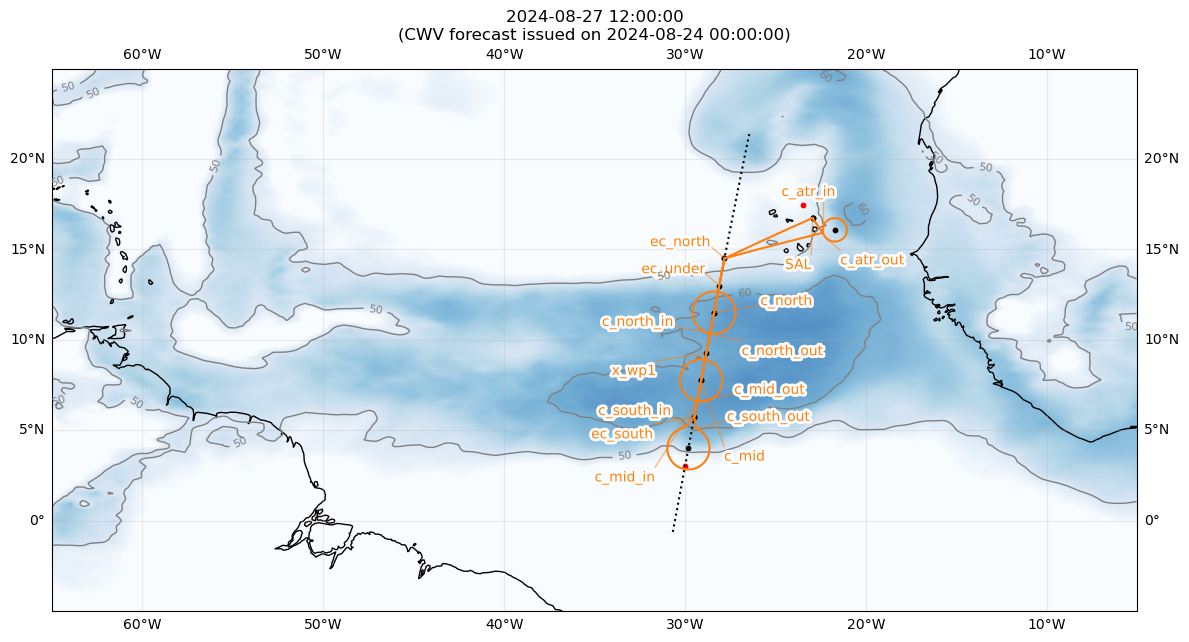

In [7]:
plt.figure(figsize = (14, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.coastlines(alpha=1.0)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

cwv_flight_time = ds["tcwv"].sel(time=flight_time, method = "nearest")
fp.plot_cwv(cwv_flight_time, levels = [50.0, 60.0])
plt.title(f"{flight_time}\n(CWV forecast issued on {issued_time})")

plt.plot(ec_lons, ec_lats, c='k', ls='dotted')

if (False):
    plt.plot([natal.lon,sal.lon], [natal.lat,sal.lat], c='purple', ls='dashed')

for wp in waypoint_centers:
    plt.scatter(wp.lon,wp.lat,s=10.,color='k')
for wp in extra_waypoints:
    plt.scatter(wp.lon,wp.lat,s=10.,color='r',marker='o')
fp.plot_path(path, ax, color="C1")
plt.savefig(f'{flight_index}_track.png')

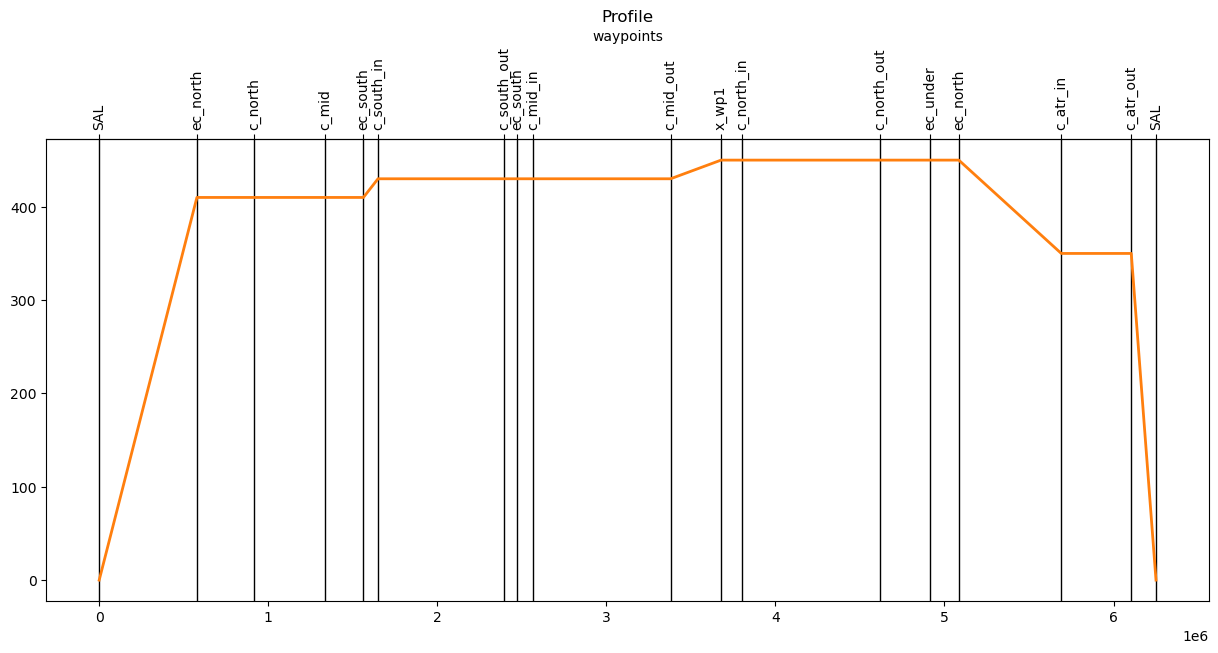

In [8]:
vertical_preview(waypoints)
plt.title("Profile")
plt.savefig(f'{flight_index}_profile.png')

In [9]:
# Detailed overview with notes
for index, row in plan.iterrows():
    if (index[0]+index[-4:]!='c_out'):
        print(f"{index:12s} {LatLon(row['lat'],row['lon']).format_pilot():20s}, FL{int(row['fl']):03d}, {takeoff_time+row['duration']:%H:%M:%S}, {notes.get(index,'')}" )
print ('\n-- circle centers:')
for point in waypoints:
    if isinstance(point, IntoCircle):
        point = point.center
        print (f'{point.label:12s} {point.format_pilot()}')
print ('\n-- extra waypoints:')
for point in extra_waypoints:
    print (f'{point.label:12s} {point.format_pilot()}, {notes.get(point.label,'')}' )
print ('\nCrew:')
for position,person in crew.items():
    print (f'{position:22s} {person}')

SAL          N16 44.07, W022 56.64, FL000, 10:11:21, 
ec_north     N14 30.00, W027 48.99, FL410, 11:00:28, 
c_north      N11 30.00, W028 23.70, FL410, 11:24:29, 
c_mid        N07 45.05, W029 06.53, FL410, 11:54:29, 
ec_south     N05 45.00, W029 28.97, FL410, 12:10:30, 
c_south_in   N05 09.67, W029 59.62, FL430, 12:16:36,  70 nm circle centered at N04 00.00, W029 48.61, enter from north, CCW
ec_south     N05 45.00, W029 28.97, FL430, 13:14:24, 
c_mid_in     N06 35.73, W029 19.51, FL430, 13:21:06,  70 nm circle centered at N07 45.05, W029 06.53, enter from south, CCW
x_wp1        N09 15.05, W028 49.51, FL450, 14:39:31, 
c_north_in   N10 20.72, W028 37.00, FL450, 14:48:07,  70 nm circle centered at N11 30.00, W028 23.70, enter from south, CCW
ec_under     N13 00.01, W028 06.45, FL450, 16:06:00, 
ec_north     N14 30.00, W027 48.99, FL450, 16:17:48, 
c_atr_in     N15 55.22, W022 22.03, FL350, 17:01:12,  39 nm circle centered at N16 04.80, W021 42.90, enter from west, CW
SAL          N16 44.

### Export kml and text file for FX and pilots

In [10]:
with open(f"{flight_index}.kml", "w") as f:
    f.write(to_kml(path))

In [11]:
with open( f"{flight_index}_waypoints.txt", "w") as file:
    file.write(f"Flight {flight_index}\n\n")
    #
    # DM Format
    file.write("------------------------------------------------------------\n")
    file.write("\nDM Format:\n")
    file.write(" ".join(wp.format_1min() for wp in waypoint_centers) + "\n")
    for point in extra_waypoints:
        file.write(f"Extra waypoint: {point.format_1min()}\n")
    #
    # DM.mm format
    file.write("\n------------------------------------------------------------\n")
    file.write("\nDMmm Format:\n")
    for point in waypoint_centers:
        file.write(f"{point.format_pilot()}, {point.label}\n")
    file.write("\n-- extra waypoints:\n")
    for point in extra_waypoints:
        file.write(f"{point.format_pilot()}, {notes.get(point.label,'')}\n")
    #
    # Detailed overview with notes
    file.write("\n------------------------------------------------------------\n")
    file.write(f"\n\nDetailed Overview:\n")
    for index, row in plan.iterrows():
        if (index[0]+index[-4:]!='c_out'):
            file.write(f"{index:12s} {LatLon(row['lat'],row['lon']).format_pilot():20s}, FL{int(row['fl']):03d}, {takeoff_time+row['duration']:%H:%M:%S}, {notes.get(index,'')}\n" )
    file.write ('\n -- circle centers:')
    for point in waypoints:
        if isinstance(point, IntoCircle):
            point = point.center
            file.write (f'\n{point.label:12s} {point.format_pilot()}')
    file.write ('\n\n -- extra waypoints:')
    for point in extra_waypoints:
        file.write (f'\n{point.label:12s} {point.format_pilot()}, {notes.get(point.label,'')}' )
    file.write ('\n\nCrew:')
    for position,person in crew.items():
        file.write (f'\n{position:22s} {person}')
